,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36
0,46,40,119,139,42,30,135,157,42,30,140,150,50,43,110,115,44,34,129,143,42,29,135,150,50,40,115,113,50,46,111,116,44,31,131,142
1,47,37,119,133,44,34,124,143,44,34,129,143,57,49,115,113,47,31,131,142,44,31,131,142,68,68,100,85,50,39,118,132,43,29,133,143
2,80,95,100,74,64,64,104,96,46,36,122,139,84,95,96,79,71,83,93,79,55,51,113,108,82,96,100,81,82,91,92,78,78,83,96,74
3,56,51,72,60,59,54,72,60,59,51,65,45,53,49,70,55,57,56,74,62,57,60,74,58,53,52,71,50,57,55,74,61,57,55,78,65
4,44,34,129,140,44,34,124,136,44,34,124,136,44,31,136,139,44,31,125,139,44,31,125,139,46,31,133,139,43,31,128,135,43,29,128,132


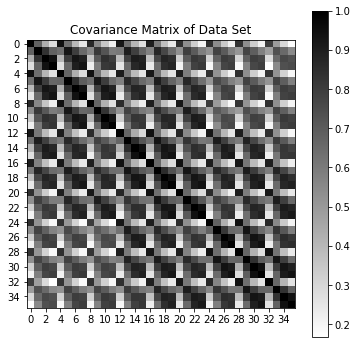

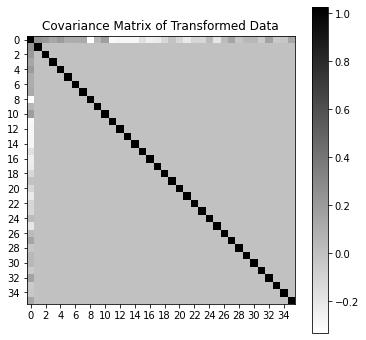

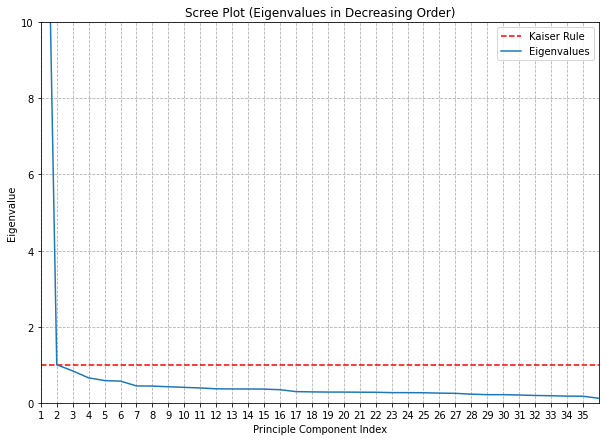

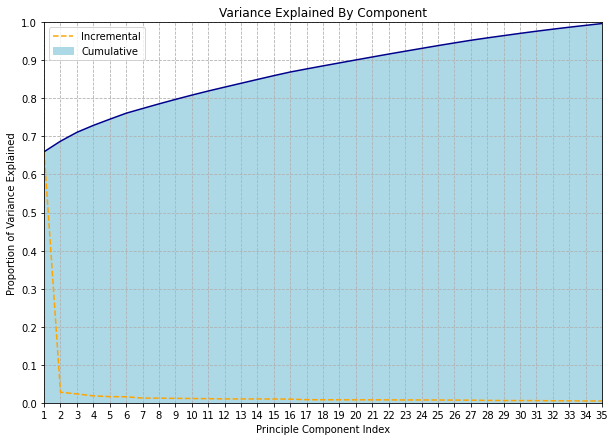

<Figure size 720x288 with 0 Axes>

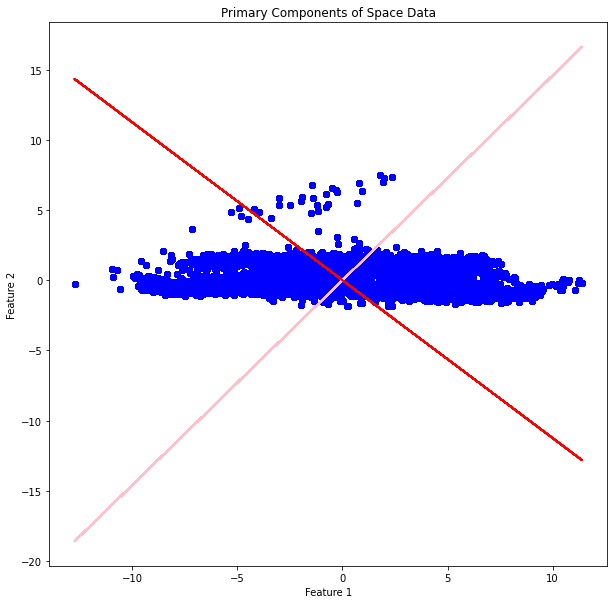

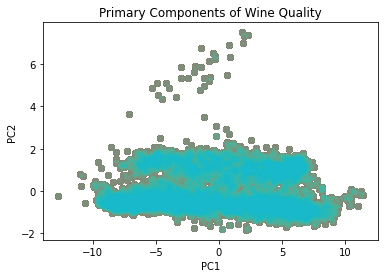

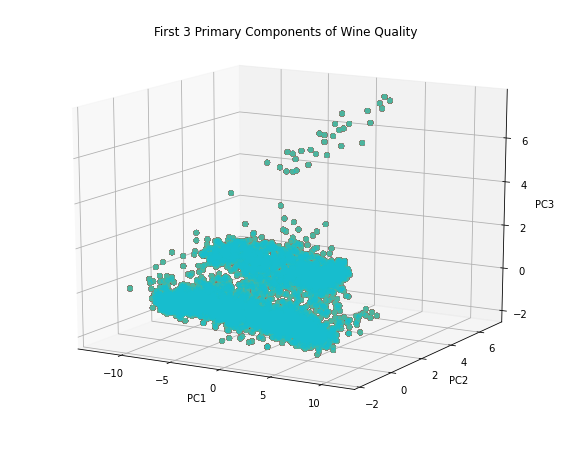

In [38]:
def outer(a,b):
    result=[]
    for i in range(len(a)):
        result.append([])
    for i in range(len(a)):
        answer = 0
        for j in range(len(a)):
            answer = a[i]*b[j]
            result[i].append(answer)
    return np.array(result)

def signfunction(a):
    if a < 0:
        return -1
    elif a == 0:
        return 0
    else:
        return 1
    
def normalise(a):
    answer = 0
    for i in range(len(a)):
        answer = answer + a[i]**2
    sqrt = answer ** (1/2)
    return sqrt

def diag(v):
    res=[]
    for i in range(len(v)):
        for j in range(len(v[i])):
            if i == j:
                res.append(v[i][j])
    return np.array(res)

def sumfunction(a):
    sum = 0
    for i in range(len(a)):
        sum = sum + a[i]
    return sum

def zeros(n):
    answer = []
    for i in range(n):
        answer.append(0)
    return np.array(answer)

def flip(a):
    answer=a[::-1]
    return np.array(answer)

def eyes(n):
    answer=[]
    for i in range(n):
        answer.append([])
    for i in range(n):
        for j in range(n):
            if i==j:
                answer[i].append(1.)
            else:
                answer[i].append(0.)
    return np.array(answer)

def mean(a):
  #5100 : row
  #36 : colu
  #a.shape 5100 36
  # a.shape[1] 36
  # a.shape[0] 5100
    result=[]
    
    a= np.array(a)
    for i in range(a.shape[1]):
        sum = 0
        counter = 0
        for j in range(a.shape[0]):
            sum = sum + a[j][i]
            counter = counter + 1
        mean = sum/counter
        result.append(mean)
    return np.array(result)

def std(a):
    a = np.array(a)
    result=[]
    mean1 = mean(a)
    var=[]
    for i in range(a.shape[1]):
        sum = 0
        counter = 0
        for j in range(a.shape[0]):
            sum = sum + (a[j][i] - mean1[i]) ** 2
            counter = counter + 1
        answer=sum / counter
        var.append(answer)
    for i in range(len(var)):
        result.append(var[i] ** (1/2))
    return result


def householder_reflection(a, e):
    '''
    Given a vector a and a unit vector e,
    (where a is non-zero and not collinear with e)
    returns an orthogonal matrix which maps a
    into the line of e.
    '''
    
    assert a.ndim == 1
    assert np.allclose(1, sumfunction(e**2))
    
    u = a - signfunction(a[0]) * normalise(a) * e  
    v = u / normalise(u)
    H = eyes(len(a)) - 2 * outer(v, v)
    
    return H


def qr_decomposition(A):
    '''
    Given an n x m invertable matrix A, returns the pair:
        Q an orthogonal n x m matrix
        R an upper triangular m x m matrix
    such that QR = A.
    '''
    n, m = A.shape
    assert n >= m
    
    Q = eyes(n)
    R = A.copy()
    
    for i in range(m - int(n==m)):
        r = R.iloc[i:, i]
        
        if np.allclose(r[1:], 0):
            continue
            
        # e is the i-th basis vector of the minor matrix.
        e = zeros(n-i)
        e[0] = 1  
        
        H = eyes(n)
        H[i:, i:] = householder_reflection(r, e)
        Q = H.T
        R = H @ R
        return Q, R
    
def eigen_decomposition(A, max_iter=100):
    A_k = A
    Q_k = eyes(A.shape[1])
    
    for k in range(max_iter):
        Q, R = qr_decomposition(A_k)
        Q_k = Q_k @ Q
        A_k = R @ Q

    eigenvalues = diag(A_k)
    eigenvectors = Q_k
    return eigenvalues, eigenvectors

class PCA:
    def __init__(self, n_components=None, whiten=False):
        self.n_components = n_components
        self.whiten = bool(whiten)
    
    def fit(self, X):
        n, m = X.shape
        
        # subtract off the mean to center the data.
        self.mu = mean(X)
        X = X - self.mu
        
        # whiten if necessary
        if self.whiten:
            self.std = std(X)
            X = X / self.std
        
        # Eigen Decomposition of the covariance matrix
        C = X.T @ X / (n-1)
        self.eigenvalues, self.eigenvectors = eigen_decomposition(C)
        
        # truncate the number of components if doing dimensionality reduction
        if self.n_components is not None:
            self.eigenvalues = self.eigenvalues[0:self.n_components]
            self.eigenvectors = self.eigenvectors[:, 0:self.n_components]
        
        # the QR algorithm tends to puts eigenvalues in descending order 
        # but is not guarenteed to. To make sure, we use argsort.
        descending_order = flip(np.argsort(self.eigenvalues))
        self.eigenvalues = self.eigenvalues[descending_order]
        self.eigenvectors = self.eigenvectors[:, descending_order]

        return self

    def transform(self, X):
        X = X - self.mu
        
        if self.whiten:
            X = X / self.std
        
        return X @ self.eigenvectors
    
    @property
    def proportion_variance_explained(self):
        return self.eigenvalues / sumfunction(self.eigenvalues)
    
        return Q, R

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

X = pd.read_csv('/content/DataSet_2.csv')
display(X.head().T)

X_white = (X - mean(X))/std(X)
C = X_white.T @ X_white / (X_white.shape[0] - 1)
#
plt.figure(figsize=(6,6))
plt.imshow(C, cmap='binary')
plt.title("Covariance Matrix of Data Set")
plt.xticks(np.arange(0, 36, 2))
plt.yticks(np.arange(0, 36, 2))
plt.colorbar()
#
pca = PCA(whiten=True)
pca.fit(X)
X_prime = pca.transform(X)
pca.eigenvalues
C_prime = pca.eigenvectors
X_white = (C_prime - mean(C_prime))/std(C_prime)
C_prime = X_white.T @ X_white / (X_white.shape[0] - 1)

#
plt.figure(figsize=(6,6))
plt.imshow(C_prime, cmap='binary')
plt.title("Covariance Matrix of Transformed Data")
plt.xticks(np.arange(0, 36, 2))
plt.yticks(np.arange(0, 36, 2))
plt.colorbar()
plt.show()
#
#
fig = plt.figure(figsize=(10, 7))
plt.title("Scree Plot (Eigenvalues in Decreasing Order)")
plt.plot([1, 36], [1, 1], color='red', linestyle='--', label="Kaiser Rule")
plt.xticks(np.arange(1, 36, 1))
plt.xlim(1, 36)
plt.ylim(0, 10)
plt.ylabel("Eigenvalue")
plt.xlabel("Principle Component Index")
plt.grid(linestyle='--')
plt.plot(range(1, 37), pca.eigenvalues, label="Eigenvalues")
plt.legend()
plt.show()
#
fig = plt.figure(figsize=(10, 7))
plt.title("Variance Explained By Component")
plt.xticks(np.arange(1, 36, 1))
plt.yticks(np.arange(0, 1.0001, 0.1))
plt.xlim(1, 35)
plt.ylim(0, 1)
plt.ylabel("Proportion of Variance Explained")
plt.xlabel("Principle Component Index")
plt.grid(linestyle='--')
plt.fill_between(
    range(1, 37), 
    np.cumsum(pca.proportion_variance_explained), 
    0, 
    color="lightblue", 
    label="Cumulative")
plt.plot(
    range(1, 37), 
    np.cumsum(pca.proportion_variance_explained), 
    0, 
    color="darkblue")
plt.plot(
    range(1, 37), 
    pca.proportion_variance_explained, 
    label="Incremental", 
    color="orange", 
    linestyle="--")
plt.legend(loc='upper left')
plt.show()
#
plt.figure(figsize=(10, 4))
x_data = X.iloc[:,0]
y_data= (pca.eigenvectors[1,0]/pca.eigenvectors[0,0])*X_prime.iloc[:,0]
y_data1= (pca.eigenvectors[1,1]/pca.eigenvectors[0,1])*X_prime.iloc[:,0]
fig = plt.figure(figsize=(10, 10))
for c in np.unique(X):
    X_class = X_prime
    plt.plot(X_prime.iloc[:,0],y_data,color='pink')
    plt.plot(X_prime.iloc[:,0],y_data1,color='red')
    plt.scatter(X_class.iloc[:,0],X_class.iloc[:,1],alpha=0.3,color='blue')  
plt.title("Primary Components of Space Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()
#
for c in np.unique(X):
    X_class = X_prime
    plt.scatter(X_class.iloc[:, 0], X_class.iloc[:, 1], alpha=0.2)
plt.title("Primary Components of Wine Quality")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
#
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(15, -60)
for c in np.unique(X):
    X_class = X_prime
    ax.scatter(X_class.iloc[:, 0], X_class.iloc[:, 2], X_class.iloc[:, 1], alpha=0.6) 
plt.title("First 3 Primary Components of Wine Quality")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()
#

